In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

import random
#import memory_profiler
import altair as alt
from tqdm import tqdm
import datetime

USE_ALL_STOCK_IDS = False
TEST_SIZE = 0.25

import os
ENV_HOME = True
if os.environ.get('USER') == 'ian':
    import ipython_memory_usage
    %ipython_memory_usage_start
    USE_TEST_LOCAL_6_ITEMS = True # robust local testing at home
else:
    assert USE_ALL_STOCK_IDS, "Must use all stocks if on Kaggle platform"
    ENV_HOME = False
    USE_TEST_LOCAL_6_ITEMS = False
    # kaggle notes:
    # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 134.74 MiB


In [2]:
# OR PASTE IN UTILITY CODE HERE FOR KAGGLE
from utility import make_unique_time_ids, get_data, get_training_stock_ids
from utility import ROOT, TEST_CSV


Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
In [2] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 134.74 MiB


## Load train set

In [3]:
stock_ids = get_training_stock_ids('book_train.parquet') # all stocks by default
if not USE_ALL_STOCK_IDS:
    # choose a random subset
    print("Using a subset")
    random.shuffle(stock_ids)
    stock_ids = stock_ids[:30]

Using a subset
In [3] used 0.4727 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 135.21 MiB


In [4]:
if 'df_train_all' not in dir():
    # only reload if necessary
    print(f"Loading {len(stock_ids)} stocks")
    df_train_all, df_book_train = get_data(stock_ids=stock_ids)
    
    df_train_all = df_train_all.set_index(['stock_id', 'time_id'])
    #df_train_all

Loading 30 stocks
There are 112 items in the folder and they look like ['stock_id=59', 'stock_id=58', 'stock_id=23', 'stock_id=17', 'stock_id=109']
Loaded 167,253,289 rows for book_train on 30 stock_ids
**** Had 428,932 rows, now we have 114,889
In [4] used 13174.4102 MiB RAM in 5.54s, peaked 38.54 MiB above current, total RAM usage 13309.62 MiB


In [5]:
all_time_ids = df_book_train.time_id.unique()
np.random.shuffle(all_time_ids) # shuffle the time_ids
print(f"We have {len(all_time_ids):,} time ids")
time_ids_train, time_ids_test = make_unique_time_ids(all_time_ids, test_size=TEST_SIZE)
assert len(time_ids_train) + len(time_ids_test) == len(all_time_ids)
assert len(time_ids_train.intersection(time_ids_test)) == 0, "Expecting no overlap between train and test time ids"
print(f"Example time ids for training, min first: {sorted(list(time_ids_train))[:5]}")

We have 3,830 time ids
Taking 2872 for train
Example time ids for training, min first: [5, 31, 62, 72, 97]
In [5] used -3150.6406 MiB RAM in 1.28s, peaked 3150.64 MiB above current, total RAM usage 10158.98 MiB


In [6]:
df_train_all.sample(5)

,,target
stock_id,time_id,
0,31814,0.001656
73,17172,0.004434
5,30692,0.002176
85,15239,0.001682
20,9060,0.001263


In [6] used -1431.9180 MiB RAM in 0.15s, peaked 1282.27 MiB above current, total RAM usage 8727.07 MiB


In [7]:
df_train_all.reset_index()['time_id'].value_counts().describe()

count    3830.000000
mean       29.997128
std         0.053522
min        29.000000
25%        30.000000
50%        30.000000
75%        30.000000
max        30.000000
Name: time_id, dtype: float64

In [7] used -872.1562 MiB RAM in 0.12s, peaked 765.46 MiB above current, total RAM usage 7854.91 MiB


In [8]:
if USE_ALL_STOCK_IDS:
    assert len(stock_ids) == 112
    if not (df_train_all.groupby('time_id').count().max()[0] == 112 and \
      df_train_all.groupby('time_id').count().min()[0] == 111):
        display(df_train_all.groupby('time_id').count().agg(['max', 'min']))
        raise Warning('Odd! Expecting 111-112')

In [8] used -543.3477 MiB RAM in 0.11s, peaked 277.81 MiB above current, total RAM usage 7311.56 MiB


In [9]:
df_train_all.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 114889 entries, (0, 5) to (125, 32767)
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   target  114889 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB
In [9] used -564.9844 MiB RAM in 0.11s, peaked 322.09 MiB above current, total RAM usage 6746.58 MiB


In [10]:
df_train_all.head()

target
stock_id time_id          
0        5        0.004136
         11       0.001445
         16       0.002168
         31       0.002195
         62       0.001747

In [10] used -362.8711 MiB RAM in 0.12s, peaked 162.82 MiB above current, total RAM usage 6383.71 MiB


# Overview

In [11]:
print(df_train_all.shape)
df_train_all.head()

(114889, 1)


target
stock_id time_id          
0        5        0.004136
         11       0.001445
         16       0.002168
         31       0.002195
         62       0.001747

In [11] used -252.8984 MiB RAM in 0.13s, peaked 161.65 MiB above current, total RAM usage 6130.81 MiB


In [12]:
df_train_all.reset_index().stock_id.value_counts().describe()

count      30.000000
mean     3829.633333
std         1.828573
min      3820.000000
25%      3830.000000
50%      3830.000000
75%      3830.000000
max      3830.000000
Name: stock_id, dtype: float64

In [12] used -28.1914 MiB RAM in 0.11s, peaked 13.47 MiB above current, total RAM usage 6102.62 MiB


In [13]:
df_train_all.reset_index().time_id.value_counts().describe()

count    3830.000000
mean       29.997128
std         0.053522
min        29.000000
25%        30.000000
50%        30.000000
75%        30.000000
max        30.000000
Name: time_id, dtype: float64

In [13] used 0.0000 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 6102.62 MiB


In [14]:
# median and interquartile range for first 10 stocks are clearly different, so these
# stocks have different behaviours
df_sample = df_train_all.reset_index().query('stock_id < 35').sample(5000)[['stock_id', 'target']]
alt.Chart(df_sample).mark_boxplot().encode(
    x='stock_id:O',
    y='target:Q'
)

alt.Chart(...)

In [14] used 1.1016 MiB RAM in 0.20s, peaked 0.63 MiB above current, total RAM usage 6103.72 MiB


# Features

In [15]:
df_book_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167253289 entries, 0 to 167253288
Data columns (total 11 columns):
 #   Column             Dtype   
---  ------             -----   
 0   time_id            int16   
 1   seconds_in_bucket  int16   
 2   bid_price1         float32 
 3   ask_price1         float32 
 4   bid_price2         float32 
 5   ask_price2         float32 
 6   bid_size1          int32   
 7   ask_size1          int32   
 8   bid_size2          int32   
 9   ask_size2          int32   
 10  stock_id           category
dtypes: category(1), float32(4), int16(2), int32(4)
memory usage: 5.8 GB
In [15] used 0.1602 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 6103.88 MiB


In [16]:
df_book_train.shape

(167253289, 11)

In [16] used 0.0430 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 6103.92 MiB


In [17]:
df_book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [17] used 0.0000 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 6103.92 MiB


In [18]:
#df_book_train.sample(5)

In [18] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 6103.92 MiB


In [19]:
df_book_train.groupby('stock_id').groups[stock_ids[0]]

Int64Index([129561230, 129561231, 129561232, 129561233, 129561234, 129561235,
            129561236, 129561237, 129561238, 129561239,
            ...
            130705797, 130705798, 130705799, 130705800, 130705801, 130705802,
            130705803, 130705804, 130705805, 130705806],
           dtype='int64', length=1144577)

In [19] used 2031.3320 MiB RAM in 4.18s, peaked 1888.37 MiB above current, total RAM usage 8135.25 MiB


In [20]:
# make feature columns
def make_features1(df_book, agg_type, cols):
    features_var1 = df_book.groupby(['stock_id', 'time_id'])[cols].agg(agg_type)
    features_var1_col_names = [f"{col}_{agg_type}" for col in cols]
    features_var1.columns = features_var1_col_names
    #features_var1
    return features_var1


In [20] used 0.0156 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 8135.27 MiB


In [21]:
# making just one column of features saves a lot of RAM
#cols = ['bid_price1', ]
#features_var1 = make_features1(df_book_train, 'var', cols)

In [21] used 0.0039 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 8135.27 MiB


In [22]:
df_book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [22] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 8135.27 MiB


<AxesSubplot:>

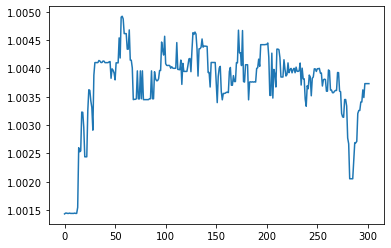

In [23] used 7020.8594 MiB RAM in 17.84s, peaked 4606.78 MiB above current, total RAM usage 15156.13 MiB


In [23]:
def make_wap(df):
    df['wap_num'] = (df['bid_price1'] * df['ask_size1']) + (df['ask_price1'] * df['bid_size1']) 
    df['wap_denom'] = df['bid_size1'] + df['ask_size1']
    df['wap'] = df['wap_num'] / df['wap_denom']
make_wap(df_book_train)
df_book_train.query('stock_id==0 and time_id==5')['wap'].plot()

In [24]:
# TODO add this back in, note we drop a row
if False:
    def log_return(list_stock_prices):
        return np.log(list_stock_prices).diff() 

    book_example.loc[:,'log_return'] = log_return(book_example['wap'])
    book_example = book_example[~book_example['log_return'].isnull()]

    def realized_volatility(series_log_return):
        return np.sqrt(np.sum(series_log_return**2))
    realized_vol = realized_volatility(book_example['log_return'])

In [24] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 15156.13 MiB


In [25]:
#cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1']

#cols = ['bid_price1', 'ask_price1', 'wap']
cols = ['wap']

features_var1 = make_features1(df_book_train, 'var', cols)
print(f"{features_var1.memory_usage().sum() / 1_000_000:0.1f} MB")
features_var1

3.2 MB


wap_var
stock_id time_id              
0        5        4.804191e-07
         11       6.865142e-08
         16       7.472485e-07
         31       5.726603e-07
         62       6.648009e-08
...                        ...
99       32751    2.103123e-07
         32753    4.110022e-07
         32758    4.128162e-07
         32763    9.205309e-08
         32767    4.511940e-08

[428960 rows x 1 columns]

In [25] used 40.5586 MiB RAM in 10.66s, peaked 5223.12 MiB above current, total RAM usage 15196.69 MiB


In [26]:
features_mean1 = make_features1(df_book_train, 'mean', cols)
features_mean1

wap_mean
stock_id time_id          
0        5        1.003725
         11       1.000239
         16       0.999542
         31       0.998832
         62       0.999619
...                    ...
99       32751    1.000644
         32753    1.000509
         32758    0.998350
         32763    0.998897
         32767    0.999571

[428960 rows x 1 columns]

In [26] used 39.8984 MiB RAM in 9.68s, peaked 5223.77 MiB above current, total RAM usage 15236.59 MiB


# Merge

In [27]:
train_merged = pd.merge(df_train_all, features_var1, left_index=True, right_index=True)
train_merged = pd.merge(train_merged, features_mean1, left_index=True, right_index=True)

train_merged

target       wap_var  wap_mean
stock_id time_id                                  
0        5        0.004136  4.804191e-07  1.003725
         11       0.001445  6.865142e-08  1.000239
         16       0.002168  7.472485e-07  0.999542
         31       0.002195  5.726603e-07  0.998832
         62       0.001747  6.648009e-08  0.999619
...                    ...           ...       ...
125      32751    0.001103  1.463967e-07  0.998980
         32753    0.001046  1.804761e-07  0.999466
         32758    0.001196  1.009255e-07  1.000720
         32763    0.005127  3.363785e-07  0.999946
         32767    0.001196  4.056145e-07  1.000780

[22980 rows x 3 columns]

In [27] used 11.2500 MiB RAM in 0.35s, peaked 0.00 MiB above current, total RAM usage 15247.84 MiB


In [28]:
features = train_merged.drop(columns='target').columns
features

Index(['wap_var', 'wap_mean'], dtype='object')

In [28] used 0.0000 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 15247.84 MiB


In [29]:
chs = []
for feature in features:
    print(f"Making {feature}")
    df_sample = train_merged.reset_index().sample(5_000)
    chs.append(alt.Chart(df_sample).mark_point().encode(x=alt.X(feature, scale=alt.Scale(zero=False)), y='target'))
    
# https://altair-viz.github.io/user_guide/compound_charts.html
alt.vconcat(*chs)

Making wap_var
Making wap_mean


alt.VConcatChart(...)

In [29] used 2.7734 MiB RAM in 0.51s, peaked 0.50 MiB above current, total RAM usage 15250.61 MiB


In [30]:
train_merged.reset_index()

,stock_id,time_id,target,wap_var,wap_mean
0,0,5,0.004136,4.804191e-07,1.003725
1,0,11,0.001445,6.865142e-08,1.000239
2,0,16,0.002168,7.472485e-07,0.999542
3,0,31,0.002195,5.726603e-07,0.998832
4,0,62,0.001747,6.648009e-08,0.999619
...,...,...,...,...,...
22975,125,32751,0.001103,1.463967e-07,0.998980
22976,125,32753,0.001046,1.804761e-07,0.999466
22977,125,32758,0.001196,1.009255e-07,1.000720
22978,125,32763,0.005127,3.363785e-07,0.999946


In [30] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 15250.61 MiB


In [31]:
def train_test_split(df, target_col, time_ids_train, time_ids_test):
    X_train = df.query('time_id in @time_ids_train').drop(columns=[target_col, 'time_id'])
    X_test = df.query('time_id in @time_ids_test').drop(columns=[target_col, 'time_id'])
    y_train = df.query('time_id in @time_ids_train')[target_col]
    y_test = df.query('time_id in @time_ids_test')[target_col]
    return X_train, X_test, y_train, y_test

feature_cols = list(features) + ['stock_id']
X_train, X_test, y_train, y_test = train_test_split(train_merged.reset_index()[feature_cols+['time_id', 'target']], 'target', time_ids_train, time_ids_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17232, 3), (5748, 3), (17232,), (5748,))

In [31] used 0.0117 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 15250.62 MiB


In [32]:
X_train.head(3)

,wap_var,wap_mean,stock_id
0,4.804191e-07,1.003725,0
3,5.726603e-07,0.998832,0
4,6.648009e-08,0.999619,0


In [32] used 0.0117 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 15250.64 MiB


In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17232, 3), (5748, 3), (17232,), (5748,))

In [33] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 15250.64 MiB


# ML on a train/test split

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [34] used 27.8320 MiB RAM in 0.59s, peaked 0.00 MiB above current, total RAM usage 15278.47 MiB


In [35]:
#est = LinearRegression()
est = RandomForestRegressor(n_estimators=10) # default n_estimators==100

In [35] used 0.0273 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 15278.50 MiB


In [36]:
est.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [36] used 0.4453 MiB RAM in 0.67s, peaked 0.00 MiB above current, total RAM usage 15278.94 MiB


In [37]:
from sklearn.metrics import r2_score

print(f"{df_train_all.reset_index().stock_id.unique().shape[0]} unique stock ids, test set is {TEST_SIZE*100:0.1f}%")
print(f"Features:", feature_cols)
y_pred = est.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"r^2 score {score:0.3f} on {y_pred.shape[0]:,} predictions")

30 unique stock ids, test set is 25.0%
Features: ['wap_var', 'wap_mean', 'stock_id']
r^2 score 0.427 on 5,748 predictions
In [37] used 0.0000 MiB RAM in 0.16s, peaked 0.00 MiB above current, total RAM usage 15278.94 MiB


In [38]:
df_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_preds['abs_diff'] = (df_preds['y_test'] - df_preds['y_pred']).abs()
df_preds.sort_values('abs_diff', ascending=False)

,y_test,y_pred,abs_diff
10049,0.034382,0.009074,2.530801e-02
9237,0.026703,0.008065,1.863780e-02
15451,0.028928,0.013158,1.576996e-02
17534,0.019625,0.005364,1.426148e-02
14342,0.016856,0.003758,1.309886e-02
...,...,...,...
20411,0.001792,0.001789,2.545700e-06
2009,0.004767,0.004767,7.996000e-07
21674,0.001340,0.001340,5.142333e-07
20830,0.001413,0.001413,3.786000e-07


In [38] used 0.0000 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 15278.94 MiB


In [39]:
alt.Chart(df_preds.sample(5000)).mark_bar().encode(
    alt.X("abs_diff:Q", bin=True),
    y='count()',)

alt.Chart(...)

In [39] used 1.9062 MiB RAM in 0.27s, peaked 0.00 MiB above current, total RAM usage 15280.85 MiB


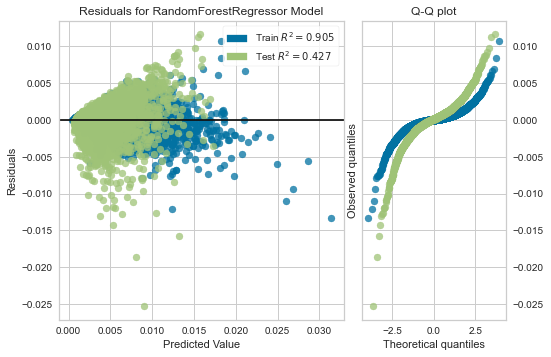

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [40] used 5.4141 MiB RAM in 1.11s, peaked 1.31 MiB above current, total RAM usage 15286.26 MiB


In [40]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(est, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()              

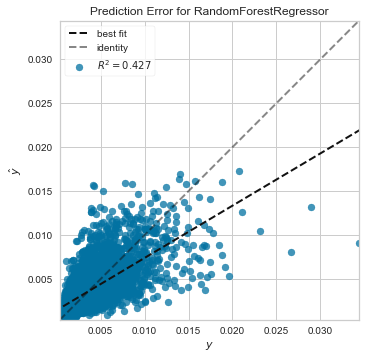

In [41] used 0.1094 MiB RAM in 0.42s, peaked 0.00 MiB above current, total RAM usage 15286.37 MiB


In [41]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(est)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
ax_subplot = visualizer.show()              
#ax_subplot.set_ylim((-0.25, 0.25))
#import matplotlib.pyplot as plt
#plt.draw()

In [42]:
if 'feature_importances_' in dir(est):
    feature_col = 'feature_importances_'
if 'coef_' in dir(est):
    feature_col = 'coef_'
df_features = pd.DataFrame(zip(getattr(est, feature_col), feature_cols), columns=['importance', 'feature']).set_index('importance')
df_features.sort_index(ascending=False)

,feature
importance,
0.475961,wap_var
0.386666,wap_mean
0.137374,stock_id


In [42] used 0.0000 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 15286.37 MiB


# Make predictions

In [43]:
len(stock_ids) # expecting 112

30

In [43] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 15286.37 MiB


In [44]:
#%xdel df_book_train

In [44] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 15286.37 MiB


In [45]:
# end of notebook

In [45] used 0.1523 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 15286.52 MiB


In [46]:
if USE_TEST_LOCAL_6_ITEMS: # True if debugging
    # book train as a substitute
    df_test_all = pd.read_csv(os.path.join(ROOT, 'test_local.csv'))
    df_test_all = df_test_all.rename(columns={'target': 'train_target'})
    TEST_FOLDER = 'book_test_local.parquet'
    assert ENV_HOME == True
else:
    df_test_all = pd.read_csv(TEST_CSV)
    if df_test_all.shape[0] == 3: # kaggle test data
        df_test_all = df_test_all[:1] # cut out 2 rows so predictions work    
    TEST_FOLDER = 'book_test.parquet'
print(ROOT, TEST_FOLDER)

df_test_all = df_test_all.set_index(['stock_id', 'time_id'])


/home/ian/data/kaggle/optiver_volatility/ book_test_local.parquet
In [46] used 0.4336 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 15286.96 MiB


In [47]:
1/0

ZeroDivisionError: division by zero

In [47] used 0.7617 MiB RAM in 0.27s, peaked 0.00 MiB above current, total RAM usage 15287.72 MiB


In [ ]:
test_set_predictions = []
stock_ids_test = get_training_stock_ids(TEST_FOLDER) # all stocks by default

df_test_predictions = pd.DataFrame() # prediction set to build up
for stock_id in tqdm(stock_ids_test):
    parquet_filename = os.path.join(ROOT, f'{TEST_FOLDER}/stock_id={stock_id}')
    #print(f"reading {parquet_filename}")
    df_book_test_stock_X = pd.read_parquet(parquet_filename)
    df_book_test_stock_X['stock_id'] = stock_id
    features_var1_test = make_features1(df_book_test_stock_X, 'var')
    features_mean1_test = make_features1(df_book_test_stock_X, 'mean')
    
    df_test_all_X = df_test_all.query('stock_id==@stock_id').copy()
    test_merged = pd.merge(df_test_all_X, features_var1_test, left_index=True, right_index=True)
    test_merged = pd.merge(test_merged, features_mean1_test, left_index=True, right_index=True)
    #test_merged = pd.merge(df_test_all_X, features_var1_test, left_index=True, right_index=True)
    test_set_predictions_X = est.predict(test_merged.reset_index()[list(features) + ['stock_id']])
    df_test_all_X['target'] = test_set_predictions_X
    df_test_predictions = pd.concat((df_test_predictions, df_test_all_X))
    
assert df_test_all.shape[0] == df_test_predictions.shape[0], "Expecting all rows to be predicted"

In [ ]:
print(f"Writing {df_test_predictions.shape[0]} rows to submission.csv on {datetime.datetime.utcnow()}")
df_test_predictions.reset_index()[['row_id', 'target']].to_csv('submission.csv', index=False)